In [1]:
import numpy as np
import pandas as pd
from sklearn import metrics
import fastsparsegams
import matplotlib.pyplot as plt

In [2]:
#hyperparameters
num_quantiles = 8
lambda_grid = [[10, 5, 2, 1, 0.5, 0.1, 0.05, 0.01]]

In [3]:
train = pd.read_csv('devel_0_train_0.csv')
val = pd.read_csv('devel_0_val_0.csv')
test = pd.read_csv('holdout_0.csv')
label = train.columns[-1]
predictors = train.columns[:-1]

In [4]:

def return_imputation(path_prefix='val_0/m_0/', label=label, predictors=predictors):
    raw_imputed_train = np.load(path_prefix+'imputed_train_x.npy')
    imputed_train = pd.DataFrame(raw_imputed_train, columns=predictors)
    imputed_train[label] = train[label]

    raw_imputed_val = np.load(path_prefix+'imputed_val_x.npy')
    imputed_val = pd.DataFrame(raw_imputed_val, columns=predictors)
    imputed_val[label] = val[label]

    raw_imputed_test = np.load(path_prefix+'imputed_test_x.npy')
    imputed_test = pd.DataFrame(raw_imputed_test, columns=predictors)
    imputed_test[label] = test[label]

    return imputed_train, imputed_val, imputed_test

In [5]:
def binarize_according_to_train(train_df, test_df, quantiles_for_binarizing = [0.2, 0.4, 0.6, 0.8], label=label):
    n_train, d_train = train_df.shape
    n_test, d_test = test_df.shape
    train, test = {}, {}
    for c in train_df.columns:
        if c == label:
            continue
        for v in list(train_df[c].quantile(quantiles_for_binarizing).unique()):
            new_col_name = f'{c} <= {v}'

            new_row_train = np.zeros(n_train)
            new_row_train[train_df[c] <= v] = 1
            train[new_col_name] = new_row_train
            
            new_row_test = np.zeros(n_test)
            new_row_test[test_df[c] <= v] = 1
            test[new_col_name] = new_row_test
   
    train[label] = train_df[label]
    test[label] = test_df[label]
    train, test = pd.DataFrame(train), pd.DataFrame(test)
    X_train, y_train = train[([c for c in train.columns if c != label])], train[label]
    X_test, y_test = test[([c for c in train.columns if c != label])], test[label]
    return X_train.values, X_test.values, y_train.values, y_test.values

In [6]:
def get_train_test_binarized(num_quantiles=num_quantiles, imputation=0): 
    path_prefix=f'val_0/m_{imputation}/'
    quantiles = np.linspace(0, 1, num_quantiles + 2)[1:-1]

    train, val, test = return_imputation(path_prefix)
    train = pd.concat([train, val])#can change to remove validation set entirely, if desired
    
    return binarize_according_to_train(train, test, quantiles)


In [7]:
def eval_model(model, X_train, X_test, y_train, y_test, provided_lambdas): 
    num_coeffs = np.zeros((len(provided_lambdas)))
    train_auc = np.zeros((len(provided_lambdas)))
    test_auc = np.zeros((len(provided_lambdas)))
    train_probs = np.zeros((len(provided_lambdas), X_train.shape[0]))
    test_probs = np.zeros((len(provided_lambdas), X_test.shape[0]))

    for lamby in model.lambda_0[0]:

        i = provided_lambdas.index(lamby)

        train_probs[i] = model.predict(X_train.astype(float),lambda_0=lamby).reshape(-1)
        fpr, tpr, _ = metrics.roc_curve(y_train, train_probs[i])
        train_auc[i] = metrics.auc(fpr, tpr)

        test_probs[i] = model.predict(X_test.astype(float),lambda_0=lamby).reshape(-1)
        fpr, tpr, _ = metrics.roc_curve(y_test, test_probs[i])
        test_auc[i] = metrics.auc(fpr, tpr)

        coeffs = (model.coeff(lambda_0=lamby).toarray().flatten())[1:] #first entry is intercept
        num_coeffs[i] = (coeffs != 0).sum()


    return train_probs, train_auc, test_probs, test_auc, num_coeffs

In [8]:
train_aucs = np.zeros((10, len(lambda_grid[0])))
test_aucs = np.zeros((10, len(lambda_grid[0])))

train_probs = np.zeros((10, len(lambda_grid[0]), train.shape[0] + val.shape[0]))
test_probs = np.zeros((10, len(lambda_grid[0]), test.shape[0]))

In [9]:
for imputation in range(10):
    X_train, X_test, y_train, y_test = get_train_test_binarized(imputation=imputation)
    model = fastsparsegams.fit(X_train, y_train, loss="Exponential", algorithm="CDPSI", lambda_grid=lambda_grid, 
                               num_lambda=None, num_gamma=None, max_support_size=200)
    train_probs[imputation], train_aucs[imputation, :], test_probs[imputation], test_aucs[imputation], _ = eval_model(
        model, X_train, X_test, y_train, y_test, lambda_grid[0])

In [10]:
ensembled_train_aucs = np.zeros(len(lambda_grid[0]))
ensembled_test_aucs = np.zeros(len(lambda_grid[0]))

ensembled_train_probs = train_probs.mean(axis=0)
ensembled_test_probs = test_probs.mean(axis=0)

In [11]:
# Alternative approaches to probabilities
# # pick some threshold, then let the AUC threshold be the number of points above that probability threshold
# seems to be worse
# ensembled_train_probs = (train_probs > 0.6).sum(axis=0)
# ensembled_test_probs = (test_probs > 0.6).sum(axis=0)
# #find value such that probability is above that for at least half of points
# seems to be about the same
# ensembled_train_probs = np.quantile(train_probs, 0.5, axis=0)
# ensembled_test_probs = np.quantile(test_probs, 0.5, axis=0)

In [12]:
for i in range(len(lambda_grid[0])):
    fpr, tpr, _ = metrics.roc_curve(y_train, ensembled_train_probs[i])
    ensembled_train_aucs[i] = metrics.auc(fpr, tpr)

    fpr, tpr, _ = metrics.roc_curve(y_test, ensembled_test_probs[i])
    ensembled_test_aucs[i] = metrics.auc(fpr, tpr)

In [13]:
nllambda = -np.log(lambda_grid[0])

### Missingness Indicator Approach

In [14]:
#our approach
def binarize_and_augment(train_df, test_df, quantiles_for_binarizing = [0.2, 0.4, 0.6, 0.8], label=label):
    n_train, d_train = train_df.shape
    n_test, d_test = test_df.shape
    train_binned, train_augmented_binned, test_binned, test_augmented_binned = {}, {}, {}, {}
    train_no_missing, test_no_missing = {}, {}
    for c in train_df.columns:
        if c == label:
            continue
        missing_col_name = f'{c} missing'
        missing_row_train = np.zeros(n_train)
        missing_row_test = np.zeros(n_test)
        for v in list(train_df[c].quantile(quantiles_for_binarizing).unique()):
            new_col_name = f'{c} <= {v}'

            new_row_train = np.zeros(n_train)
            new_row_train[train_df[c] <= v] = 1
            train_no_missing[new_col_name] = new_row_train
            train_binned[new_col_name] = new_row_train
            train_augmented_binned[new_col_name] = new_row_train
            
            new_row_test = np.zeros(n_test)
            new_row_test[test_df[c] <= v] = 1
            test_no_missing[new_col_name] = new_row_test
            test_binned[new_col_name] = new_row_test
            test_augmented_binned[new_col_name] = new_row_test

        missing_row_train[train_df[c].isna()] = 1
        missing_row_test[test_df[c].isna()] = 1

        train_binned[missing_col_name] = missing_row_train
        train_augmented_binned[missing_col_name] = missing_row_train
    
        test_binned[missing_col_name] = missing_row_test
        test_augmented_binned[missing_col_name] = missing_row_test
    
    for c_outer in train_df.columns:
        if c_outer == label:
            continue
        for c_inner in train_df.columns:
            for v in train_df[c_inner].quantile(quantiles_for_binarizing).unique():
                if c_inner == label:
                    continue
                else:
                    missing_ixn_name = f'{c_outer} missing & {c_inner} <= {v}'
                    missing_ixn_row_train = np.zeros(n_train)
                    missing_ixn_row_test = np.zeros(n_test)

                    missing_ixn_row_train[(train_df[c_outer].isna()) & (train_df[c_inner] <= v)] = 1
                    missing_ixn_row_test[(test_df[c_outer].isna()) & (test_df[c_inner] <= v)] = 1

                    train_augmented_binned[missing_ixn_name] = missing_ixn_row_train
                    test_augmented_binned[missing_ixn_name] = missing_ixn_row_test
                        
    train_binned[label] = train_df[label]
    test_binned[label] = test_df[label]
    train_no_missing[label] = train_df[label]
    test_no_missing[label] = test_df[label]
    train_augmented_binned[label] = train_df[label]
    test_augmented_binned[label] = test_df[label]

    
    return (pd.DataFrame(train_no_missing)[[c for c in train_no_missing.keys() if c != label]].values, 
            pd.DataFrame(train_binned)[[c for c in train_binned.keys() if c != label]].values, 
            pd.DataFrame(train_augmented_binned)[[c for c in train_augmented_binned.keys() if c != label]].values,
            pd.DataFrame(test_no_missing)[[c for c in test_no_missing.keys() if c != label]].values, 
            pd.DataFrame(test_binned)[[c for c in test_binned.keys() if c != label]].values, 
            pd.DataFrame(test_augmented_binned)[[c for c in test_augmented_binned.keys() if c != label]].values, 
            pd.DataFrame(train_no_missing)[label].values, 
            pd.DataFrame(train_binned)[label].values, 
            pd.DataFrame(train_augmented_binned)[label].values,
            pd.DataFrame(test_no_missing)[label].values, 
            pd.DataFrame(test_binned)[label].values, 
            pd.DataFrame(test_augmented_binned)[label].values, 
    )



In [15]:
train = pd.read_csv('devel_0_train_0.csv')
val = pd.read_csv('devel_0_val_0.csv')
test = pd.read_csv('holdout_0.csv')

(train_no, train_ind, train_aug, 
 test_no, test_ind, test_aug, 
 y_train_no, y_train_ind, y_train_aug, 
 y_test_no, y_test_ind, y_test_aug) = binarize_and_augment(pd.concat([train, val]), test, 
                                                               np.linspace(0, 1, num_quantiles + 2)[1:-1] )

In [16]:
model_no = fastsparsegams.fit(train_no, y_train_no, loss="Exponential", algorithm="CDPSI", lambda_grid=lambda_grid, 
                              num_lambda=None, num_gamma=None, max_support_size=200)
train_probs_no, train_aucs_no, test_probs_no, test_aucs_no, _ = eval_model(
    model_no, train_no, test_no, y_train_no, y_test_no, lambda_grid[0]
    )
model_ind = fastsparsegams.fit(train_ind, y_train_ind, loss="Exponential", algorithm="CDPSI", lambda_grid=lambda_grid, 
                               num_lambda=None, num_gamma=None, max_support_size=200)
train_probs_ind, train_aucs_ind, test_probs_ind, test_aucs_ind, _ = eval_model(
    model_ind, train_ind, test_ind, y_train_ind, y_test_ind, lambda_grid[0]
    )

In [17]:
model_aug = fastsparsegams.fit(train_aug, y_train_aug, loss="Exponential", algorithm="CDPSI", 
                               lambda_grid=lambda_grid, num_lambda=None, num_gamma=None, max_support_size=50)
train_probs_aug, train_aucs_aug, test_probs_aug, test_aucs_aug, _ = eval_model(
    model_aug, train_aug, test_aug, y_train_aug, y_test_aug, lambda_grid[0]
    )

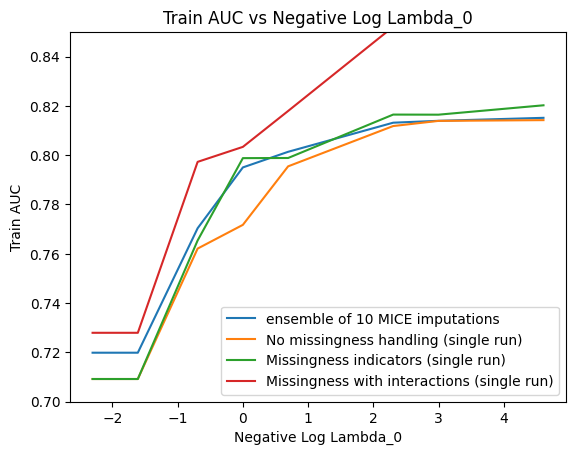

In [18]:
plt.title('Train AUC vs Negative Log Lambda_0')
plt.plot(nllambda, ensembled_train_aucs, label='ensemble of 10 MICE imputations')
plt.plot(nllambda, train_aucs_no, label='No missingness handling (single run)')
plt.plot(nllambda, train_aucs_ind, label='Missingness indicators (single run)')
plt.plot(nllambda[train_aucs_aug > 0], train_aucs_aug[train_aucs_aug > 0], label='Missingness with interactions (single run)')
plt.xlabel('Negative Log Lambda_0')
plt.ylabel('Train AUC')
plt.legend()
plt.ylim(0.7, 0.85)
plt.show()

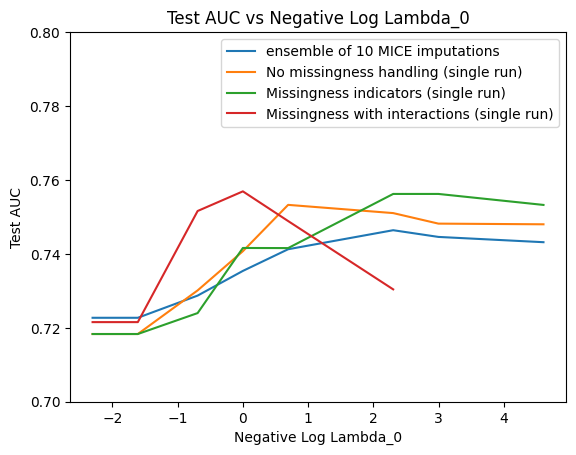

In [19]:
plt.title('Test AUC vs Negative Log Lambda_0')
plt.plot(nllambda, ensembled_test_aucs, label='ensemble of 10 MICE imputations')
plt.plot(nllambda, test_aucs_no, label='No missingness handling (single run)')
plt.plot(nllambda, test_aucs_ind, label='Missingness indicators (single run)')
plt.plot(nllambda[train_aucs_aug > 0], test_aucs_aug[train_aucs_aug > 0], label='Missingness with interactions (single run)')
plt.xlabel('Negative Log Lambda_0')
plt.ylabel('Test AUC')
plt.legend()
plt.ylim(0.7, 0.8)
plt.show()